In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
from sklearn import set_config
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer


In [2]:
account_dim = pd.read_csv('reduced_account_dim.csv')
rams_batch_cur = pd.read_csv('reduced_rams_batch_cur.csv')
syf_id = pd.read_csv('reduced_syf_id.csv')
fraud_claim_case = pd.read_csv('reduced_fraud_claim_case.csv')
transaction_fact = pd.read_csv('reduced_transaction_fact.csv')
fraud_claim_tran = pd.read_csv('reduced_fraud_claim_tran.csv')

In [3]:
account_dim['open_date'] = pd.to_datetime(account_dim['open_date'], errors='coerce', utc=True)
account_dim['card_activation_date'] = pd.to_datetime(account_dim['card_activation_date'], errors='coerce', utc=True)

# Get the current date as a Timestamp in UTC
curr = pd.Timestamp('2025-03-25 04:00:00+00:00')

# Compute the difference in days for open_date
account_dim['open_date_diff'] = (curr - account_dim['open_date']).dt.total_seconds() / 86400.0

# Compute the difference in days for card_activation_date, replacing missing values with 0
account_dim['card_activation_date_diff'] = (curr - account_dim['card_activation_date']).dt.total_seconds() / 86400.0
account_dim['card_activation_date_diff'] = account_dim['card_activation_date_diff'].fillna(0)

account_dim = account_dim.drop(columns= 'payment_hist_1_12_mths', axis='columns')
account_dim = account_dim.drop(columns= 'payment_hist_13_24_mths', axis='columns')

In [4]:
merged_data = account_dim.merge(rams_batch_cur, left_on='current_account_nbr', right_on='cu_account_nbr', how='left')
merged_data = merged_data.merge(syf_id, left_on='current_account_nbr', right_on='account_nbr_pty', how='left')
merged_data = merged_data.merge(fraud_claim_case, on='current_account_nbr', how='left')

# Merge the most recent transaction records.
merged_data = merged_data.merge(transaction_fact, on='current_account_nbr', how='left', suffixes=('', '_trans'))
merged_data = merged_data.merge(fraud_claim_tran, on='current_account_nbr', how='left', suffixes=('', '_fraud'))

merged_data.fillna(0, inplace=True)

/var/folders/vt/qhfy_ndx33b06w_89gzyz1v40000gn/T/ipykernel_41976/1345828342.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns, UTC], please explicitly cast to a compatible dtype first.
  merged_data.fillna(0, inplace=True)


In [ ]:
merged_data['cu_cash_line_am'] = merged_data['cu_cash_line_am'].replace(
    999_999_999_999.0,
    0.0 
)
# Optional: Remove rows where credit line is 0
merged_data = merged_data[merged_data['cu_cash_line_am'] > 0]

cols_to_drop = [
    'current_account_nbr', 'cu_account_nbr', 'ds_id', 'account_nbr_pty', 'open_date_y', 
    'ebill_ind', 'account_card_type', 'cu_line_incr_excl_flag', 'rb_crd_gr_new_crd_gr', 
    'confidence_level', 'adj_orgn_tran_dt', 'first_purchase_ind', 'transaction_date', 
    'transaction_type', 'case_id', 'open_date_x', 'posting_date', 'case_id_fraud',
    'transaction_code', 'invoice_nbr'
]
merged_data = merged_data.drop(columns=cols_to_drop, axis = 'column')

In [22]:
# Define risk thresholds at the top for easy tuning
LOW_UTIL_MAX = 13      # <13% utilization → no increase
SAFE_UTIL_MAX = 23      # 13-23% utilization + clean history → low risk
GROSS_FRAUD_BAR = 100   # $100+ fraud → moderate/high risk
SEVERE_DLQ_DAYS = 30    # >30 days delinquent → high risk

def engineer_targets(row):
    # High Risk: Severe delinquency or recurring fraud
    if (row['cu_nbr_days_dlq'] >= SEVERE_DLQ_DAYS) or \
       (row['gross_fraud_amt'] >= GROSS_FRAUD_BAR):
        return pd.Series({'account_segment': 3, 'credit_line_increase': 0})

    # No Increase: Very low utilization
    if row['ca_avg_utilz_lst_3_mnths'] < LOW_UTIL_MAX:
        return pd.Series({'account_segment': 2, 'credit_line_increase': 0})

    # Low Risk: Clean history + safe utilization
    if (row['cu_nbr_days_dlq'] == 0) and \
       (row['gross_fraud_amt'] < GROSS_FRAUD_BAR) and \
       (row['ca_avg_utilz_lst_3_mnths'] < SAFE_UTIL_MAX):
        return pd.Series({
            'account_segment': 0,
            'credit_line_increase': row['cu_cash_line_am'] * 0.20
        })

    # Moderate Risk: Everything else
    increase = row['cu_cash_line_am'] * 0.10 if \
        (row['cu_nbr_days_dlq'] < SEVERE_DLQ_DAYS) and \
        (row['gross_fraud_amt'] < GROSS_FRAUD_BAR * 2) else 0
        
    return pd.Series({'account_segment': 1, 'credit_line_increase': increase})

merged_data[['account_segment', 'credit_line_increase']] = merged_data.apply(engineer_targets, axis=1)

In [23]:
X = merged_data.drop(columns=['account_segment', 'credit_line_increase', 'card_activation_date'], axis = 'column')

# List the columns used in target engineering
leakage_cols = ['ca_avg_utilz_lst_3_mnths', 'cu_nbr_days_dlq', 'gross_fraud_amt', 
                'cu_cash_line_am', 'cu_cur_balance', 
                'rb_new_bhv_scr']

# Remove target columns and leakage columns from the dataset
X = merged_data.drop(columns=leakage_cols + ['account_segment', 'credit_line_increase'], axis = 'column')
X = X.drop(columns="card_activation_date", axis='columns')
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.95)]
# Remove duplicates
X = X.drop(columns=high_corr)


X.head

<bound method NDFrame.head of          card_activation_flag  open_date_diff  card_activation_date_diff  \
0                         8.0     1712.000000                   0.000000   
1                         8.0     1712.000000                   0.000000   
2                         8.0     1712.000000                   0.000000   
3                         8.0     1712.000000                   0.000000   
4                         8.0     1712.000000                   0.000000   
...                       ...             ...                        ...   
2973412                   7.0      483.958333                   0.000000   
2973413                   7.0      483.958333                   0.000000   
2973414                   7.0      483.958333                   0.000000   
2973427                   0.0      607.000000                  63.958333   
2973428                   0.0      607.000000                  63.958333   

         cu_bhv_scr  ca_avg_utilz_lst_6_mnths  cu_crd_bur

In [24]:
y_class = merged_data['account_segment']
y_reg = merged_data['credit_line_increase']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

In [25]:
classifier = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    max_depth=5,               # Reduce from default 6
    subsample=0.8,             # Prevent over-reliance on specific samples
    colsample_bytree=0.7,      # Limit feature usage per tree
    learning_rate=0.1,         # Slow down learning
    reg_alpha=1,               # L1 regularization
    reg_lambda=10,             # L2 regularization 
    eval_metric='mlogloss',
    n_estimators=200
)
class_weights = compute_class_weight('balanced', classes=np.unique(y_class), y=y_class)
classifier.set_params(scale_pos_weight=class_weights)

classifier.fit(X_train_class, y_train_class)
set_config(display='text')

y_pred_class = classifier.predict(X_test_class)
print("Classification Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))

# Build and train the regression model
regressor = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)
regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = regressor.predict(X_test_reg)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
print("Regression RMSE:", rmse)


/opt/anaconda3/envs/octopus/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:48:17] WARNING: /var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_d9k8pmaj4_/croot/xgboost-split_1724073758172/work/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Accuracy: 0.9352501993009137
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.87      0.86     88988
         1.0       0.95      0.96      0.95    100076
         2.0       0.96      0.95      0.96    196976
         3.0       1.00      1.00      1.00      5328

    accuracy                           0.94    391368
   macro avg       0.94      0.94      0.94    391368
weighted avg       0.94      0.94      0.94    391368

Regression RMSE: 103.98042904354122


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

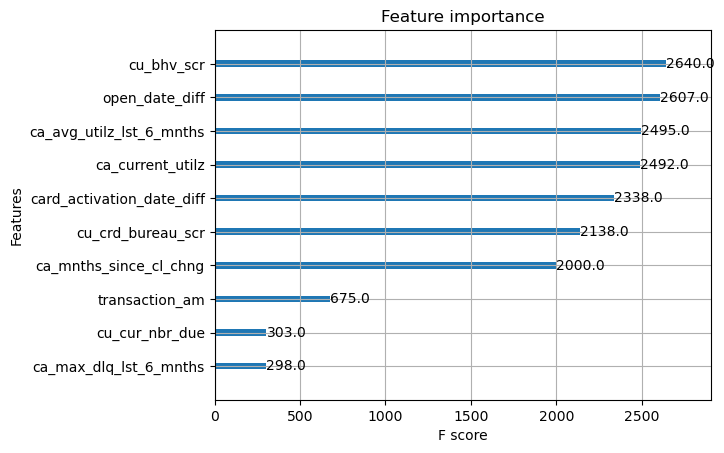

In [26]:
from xgboost import plot_importance
plot_importance(classifier, max_num_features=10)


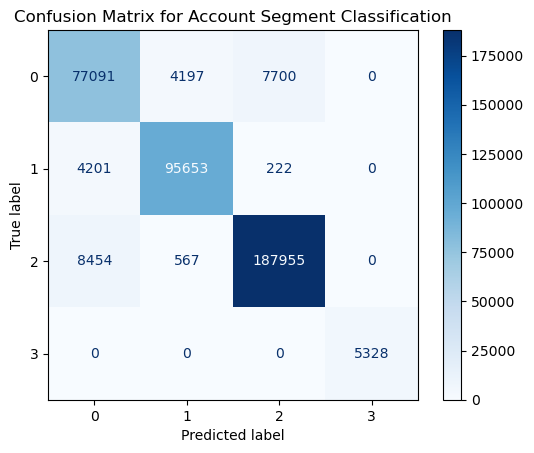

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Account Segment Classification")
plt.show()


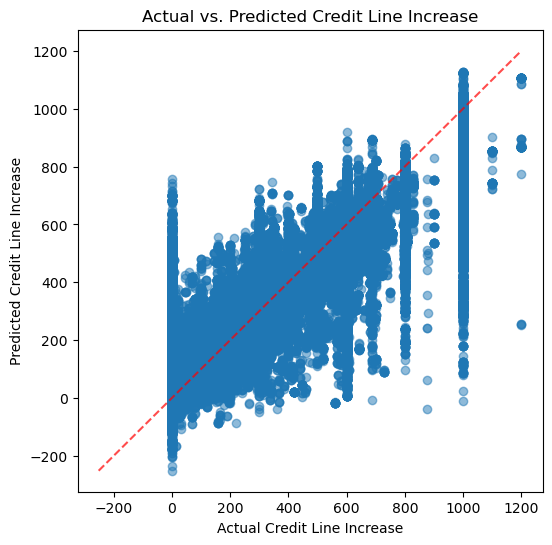

In [28]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.xlabel("Actual Credit Line Increase")
plt.ylabel("Predicted Credit Line Increase")
plt.title("Actual vs. Predicted Credit Line Increase")

# Plot a 45-degree reference line for perfect predictions
lims = [min(min(y_test_reg), min(y_pred_reg)), max(max(y_test_reg), max(y_pred_reg))]
plt.plot(lims, lims, 'r--', alpha=0.7)
plt.show()


In [29]:
valid_accounts = merged_data[merged_data['account_segment'].isin([0,1])]

utilization_rate = merged_data['ca_current_utilz'].mean()/1e2

# Conservative assumptions (adapt with business input):
interest_rate = 0.18      # Annual APR

revenue_lift = (
    valid_accounts['credit_line_increase'] 
    * utilization_rate 
    * interest_rate
).sum()

print(f"Annual Revenue Lift: ${revenue_lift:,.2f}")


Annual Revenue Lift: $14,585,857.55


In [30]:
# Calculate preventable fraud in high-risk accounts
high_risk_fraud = merged_data[merged_data['account_segment'].isin([2, 3])]['gross_fraud_amt'].sum()


# Industry-standard prevention rate (Javelin Strategy 2023)
prevention_rate = 0.68  

fraud_savings = high_risk_fraud * prevention_rate
print(f"Projected Fraud Savings: ${fraud_savings:,.2f}")


Projected Fraud Savings: $2,307,769.94


In [31]:
auto_approved = merged_data[merged_data['account_segment'] != 3].shape[0]
total_accounts = merged_data.shape[0]

# Assumptions (adapt with operations team):
review_time = 15  # Minutes per account
analyst_capacity = 30  # Accounts/day

time_saved = ((auto_approved * review_time)/60) / analyst_capacity
print(f"FTE Capacity Saved: {time_saved:.1f} analysts")
print(auto_approved)

FTE Capacity Saved: 16082.4 analysts
1929884


In [32]:
(revenue_lift/1e6, valid_accounts.shape[0], fraud_savings/1e6)


(14.585857547523911, 946681, 2.3077699443999995)

In [33]:
print(f"Final Training Shape: {X_train_class.shape}")  
# 586,880 accounts × 22 features


Final Training Shape: (1565472, 19)


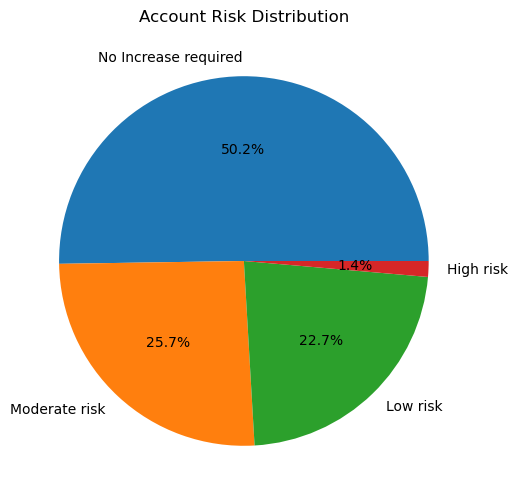

In [36]:
# Define a mapping from segment code to label
segment_labels = {
    0: "Low risk",
    1: "Moderate risk",
    2: "No Increase required",
    3: "High risk"
}

# Get the value counts for each account segment
seg_counts = merged_data['account_segment'].value_counts()

# Map the index (segment codes) to their corresponding labels
labels = seg_counts.index.map(lambda x: segment_labels.get(x, str(x)))

plt.figure(figsize=(8,6))
seg_counts.plot.pie(autopct='%1.1f%%', labels=labels)
plt.title("Account Risk Distribution")
plt.ylabel("")  # Optional: remove the default y-label
plt.show()
